# Fig. 2. Treatment-induced increase of voxel-based physiology in the left dorsolateral prefron-tal cortex.

In [1]:
# set_env.py is not included in the repo
# it defines $HCP_DENSE_PATH, $PROJECT_DIR (required) and $HCP_DIR (optional)
# in environment variables
import set_env

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import neuromaps.transforms


sys.path.append("../scripts")
from utils import io, transform, plot

## Run ALE

ALE is performed using pyALE within `../ale/run.py`. This script is run as a HTCondor job through `condor_submit run.submit` which submits a HTCondor job that executes `run.sh` which itself is a wrapper for `run.py`.

In [12]:
!condor_submit ../scripts/ale/run.submit

Submitting job(s).
1 job(s) submitted to cluster 3580726.


In [13]:
!cp ../logs/3580930.0.out ../results/ale/ale_results_summary.txt

In [14]:
!cat ../results/ale/ale_results_summary.txt

/home/asaberi/antidepressants_ale/scripts/ale/../../results/ale/All analysis.xlsx coordinates.xlsx
enter main
All : 30 experiments; average of 22.03 subjects per experiment
All - illustrate Foci
All - computing ALE and null PDF
All - computing p-values & TFCE
All - simulating null
All - inference and printing
Min p-value for FWE:1.0
Min p-value for cFWE:0.3874
Min p-value for TFCE:1.0
All - done!
/home/asaberi/antidepressants_ale/scripts/ale/../../results/ale/All_exc_Ketamine analysis.xlsx coordinates.xlsx
enter main
All_exc_Ketamine : 23 experiments; average of 22.74 subjects per experiment
All_exc_Ketamine - illustrate Foci
All_exc_Ketamine - computing ALE and null PDF
All_exc_Ketamine - computing p-values & TFCE
All_exc_Ketamine - simulating null
All_exc_Ketamine - inference and printing
Min p-value for FWE:1.0
Min p-value for cFWE:0.4864
Min p-value for TFCE:1.0
All_exc_Ketamine - done!
/home/asaberi/antidepressants_ale/scripts/ale/../../results/ale/All_gt4wk analysis.xlsx coordina

## A. Peak coordinates of antidepressant effects

In [4]:
# load inc coordiantes
coordinates = io.load_coordinates("Contrast", "Untreated<Treated")
# load coordiantes of CIFTI coordinates and
# get closest CIFTI grayordinates to each coordinate
all_xyz = transform.get_cifti_mni_coordinates()
dist_mat = scipy.spatial.distance_matrix(coordinates, all_xyz)
inc_points = dist_mat.argmin(axis=1)
closest_dist = dist_mat.min(axis=1)
inc_points = inc_points[closest_dist < 10]
# load dec coordiantes
coordinates = io.load_coordinates("Contrast", "Untreated>Treated")
dist_mat = scipy.spatial.distance_matrix(coordinates, all_xyz)
dec_points = dist_mat.argmin(axis=1)
closest_dist = dist_mat.min(axis=1)
dec_points = dec_points[closest_dist < 10]

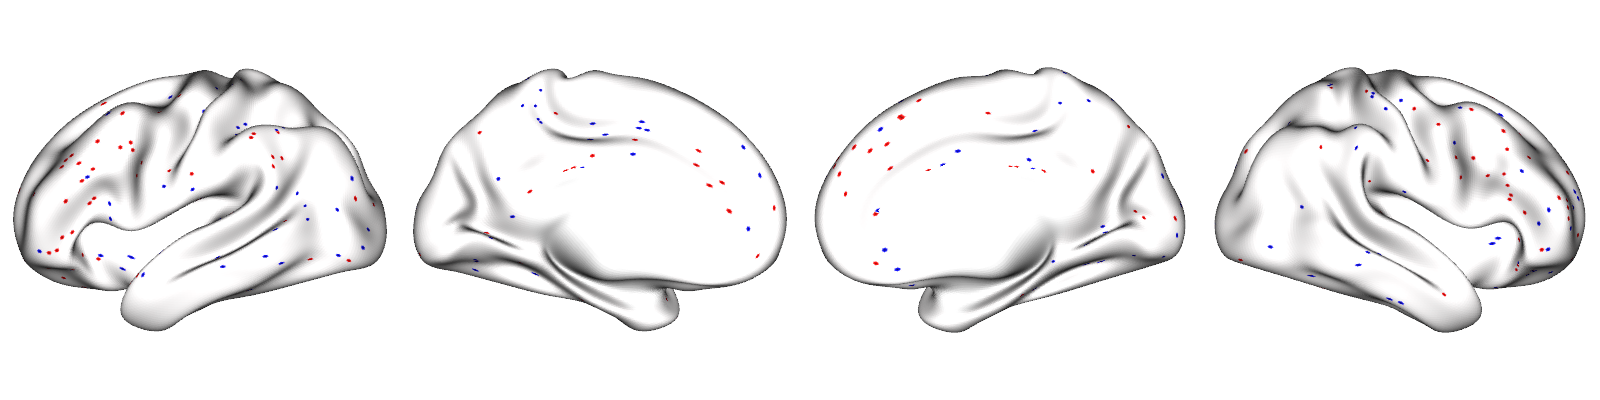

In [4]:
foci_cifti = np.zeros(transform.CIFTI_NPOINTS)
foci_cifti[inc_points] = 1
foci_cifti[dec_points] = -1
foci_fslr = transform.cifti_to_fsLR(foci_cifti)
foci_fslr = np.concatenate([foci_fslr["L"].flatten(), foci_fslr["R"].flatten()])
plot.plot_surface(foci_fslr, cmap="seismic", nan_color=(1, 1, 1, 1.0))

## B. ALE cluster of Treated > Untreated

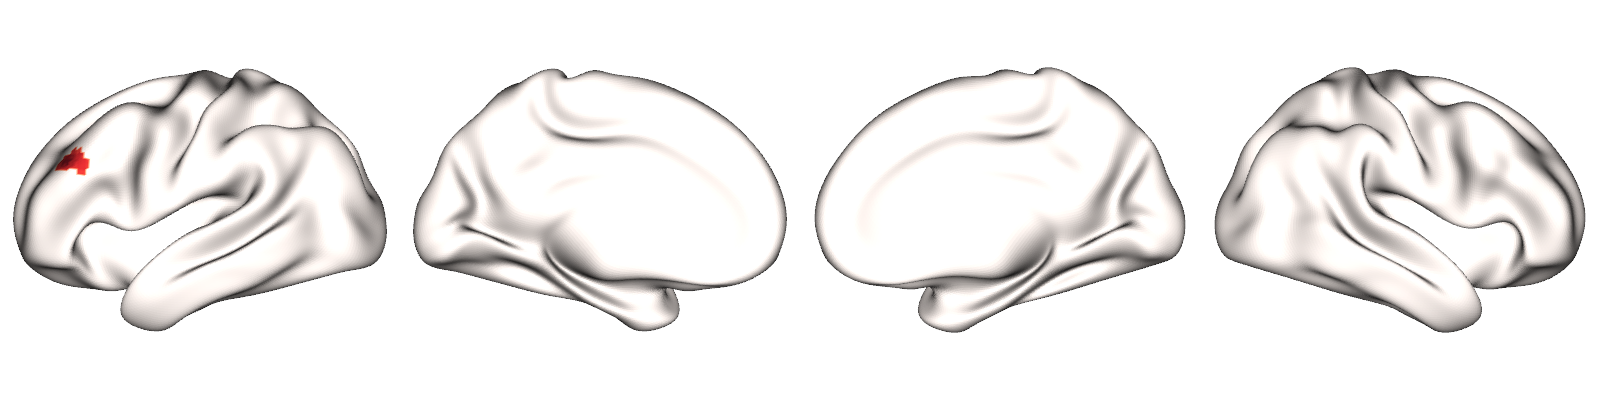

In [15]:
cluster_nifti = os.path.join(
    io.RESULTS_DIR,
    "ale",
    "Contrast",
    "Results",
    "MainEffect",
    "Full",
    "Volumes",
    "Corrected",
    "Contrast_increased_cFWE05.nii",
)
cluster_fslr = neuromaps.transforms.mni152_to_fslr(cluster_nifti, method="nearest")
cluster_fslr = np.concatenate([cluster_fslr[0].agg_data(), cluster_fslr[1].agg_data()])
plot.plot_surface(cluster_fslr, cmap="Reds", nan_color=(0.65, 0.65, 0.65, 1.0))

## Text. Contribution analysis

In [27]:
contrib_file_path = os.path.join(
    io.RESULTS_DIR,
    "ale",
    "Contrast",
    "Results",
    "MainEffect",
    "Full",
    "Contribution",
    "Contrast_increased_cFWE.txt",
)
with open(contrib_file_path, "r") as f:
    contrib_text_lines = f.read().split("\n")

contrib_data = []
for line in contrib_text_lines[7:14]:
    contrib_data.append(line.split("\t"))
contrib_data = pd.DataFrame(contrib_data)
contrib_data[0] = contrib_data[0].str.strip()
contrib_data[[1, 2, 3, 4]] = contrib_data[[1, 2, 3, 4]].astype("float")
contrib_data = contrib_data.drop(columns=[1, 2, 4, 5])
contrib_data.columns = ["experiment", "contribution"]
contrib_data

,experiment,contribution
0,Cheng_2016,24.46
1,Kennedy_2001,17.24
2,Kohn_2008,0.25
3,Komulainen_2018_2021,2.80
4,Li_2015,25.30
5,Mayberg_2000,13.78
6,Williams_2021,16.13


In [17]:
# entered these manually from Table 1
contrib_data["modality"] = ["fMRI", "PET", "SPECT", "fMRI", "PET", "PET", "fMRI"]
contrib_data["rest"] = ["Yes", "Yes", "Yes", "No", "Yes", "Yes", "No"]
contrib_data["med"] = ["SSRI", "SSRI", "Variable", "SSRI", "Ketamine", "SSRI", "Variable",]

In [18]:
contrib_data

,experiment,contribution,modality,rest,med
0,Cheng_2016,24.46,fMRI,Yes,SSRI
1,Kennedy_2001,17.24,PET,Yes,SSRI
2,Kohn_2008,0.25,SPECT,Yes,Variable
3,Komulainen_2018_2021,2.80,fMRI,No,SSRI
4,Li_2015,25.30,PET,Yes,Ketamine
5,Mayberg_2000,13.78,PET,Yes,SSRI
6,Williams_2021,16.13,fMRI,No,Variable


In [19]:
contrib_data.groupby("med")["contribution"].sum()

med
Ketamine    25.30
SSRI        58.28
Variable    16.38
Name: contribution, dtype: float64

In [24]:
contrib_data.groupby("modality")["contribution"].sum()

modality
PET      56.32
SPECT     0.25
fMRI     43.39
Name: contribution, dtype: float64

In [25]:
contrib_data.groupby("rest")["contribution"].sum()

rest
No     18.93
Yes    81.03
Name: contribution, dtype: float64